In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
import torch
from torch import nn
from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

In [2]:
from text_recognizer.networks import CTCTransformer

In [9]:
model = CTCTransformer(
        num_encoder_layers=2,
        hidden_dim=256,
        vocab_size=56,
        num_heads=8,
        adaptive_pool_dim=[None, 1],
        expansion_dim=2048,
        dropout_rate=0.1,
        max_len=256,
        patch_size=(28, 32),
        stride=(1, 28),
        activation="gelu",
        backbone="WideResidualNetwork",
backbone_args={
            "in_channels": 1,
            "in_planes": 64,
            "num_classes": 80,
            "depth": 10,
            "width_factor": 1,
            "dropout_rate": 0.1,
            "num_layers": 4,
            "num_stages": [64, 128, 256, 256],
            "activation": "elu",
            "use_decoder": False,
},
 )

In [ ]:
backbone: WideResidualNetwork
          backbone_args:
            in_channels: 1
            in_planes: 64
            num_classes: 80
            depth: 10
            width_factor: 1
            dropout_rate: 0.1
            num_layers: 4 
            num_stages: [64, 128, 256, 256]
            activation: elu
            use_decoder: false
          n

In [2]:
t = torch.randn(2, 1, 28, 952)

In [3]:
t.view(-1, 952).shape

torch.Size([56, 952])

In [14]:
model(t).shape

torch.Size([119, 2, 56])

In [8]:
summary(model, (1, 28, 952), device="cpu", depth=3)

RuntimeError: Failed to run torchsummary. See above stack traces for more details. Executed layers up to: [WideResidualNetwork: 1-1, Sequential: 2-1, Conv2d: 3-1, Sequential: 3-2, WideBlock: 4-1, Sequential: 3-3, WideBlock: 4-2, Sequential: 3-4, WideBlock: 4-3, Sequential: 3-5, WideBlock: 4-4, AdaptiveAvgPool2d: 1-2, Encoder: 1-3, EncoderLayer: 3-6, MultiHeadAttention: 4-5, _IntraLayerConnection: 4-6, _ConvolutionalLayer: 4-7, _IntraLayerConnection: 4-8, EncoderLayer: 3-7, MultiHeadAttention: 4-9, _IntraLayerConnection: 4-10, _ConvolutionalLayer: 4-11, _IntraLayerConnection: 4-12, LayerNorm: 2-2, Linear: 2-3, GLU: 2-4]

In [29]:
class GEGLU(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.proj = nn.Linear(dim_in, dim_out * 2)

    def forward(self, x):
        x, gate = self.proj(x).chunk(2, dim = -1)
        return x * F.gelu(gate)

In [16]:
e = GEGLU(256, 2048)

In [17]:
e(t).shape

torch.Size([1, 30, 2048])

In [34]:
emb = nn.Embedding(56, 256)

In [41]:
with torch.no_grad():
    e = emb(torch.Tensor([55]).long())

In [43]:
from einops import repeat

In [46]:
ee = repeat(e, "() n -> b n", b=16)

In [58]:
emb.device

ModuleAttributeError: 'Embedding' object has no attribute 'device'

In [49]:
ee

tensor([[-1.0624,  0.0674,  0.9387,  ..., -0.1852, -0.1303,  0.8005],
        [-1.0624,  0.0674,  0.9387,  ..., -0.1852, -0.1303,  0.8005],
        [-1.0624,  0.0674,  0.9387,  ..., -0.1852, -0.1303,  0.8005],
        ...,
        [-1.0624,  0.0674,  0.9387,  ..., -0.1852, -0.1303,  0.8005],
        [-1.0624,  0.0674,  0.9387,  ..., -0.1852, -0.1303,  0.8005],
        [-1.0624,  0.0674,  0.9387,  ..., -0.1852, -0.1303,  0.8005]])

In [47]:
ee.shape

torch.Size([16, 256])

In [50]:
t = torch.randn(16, 10, 256)

In [52]:
t.shape

torch.Size([16, 10, 256])

In [56]:
t = torch.cat((ee.unsqueeze(1), t, ee.unsqueeze(1)), dim=1)

In [57]:
t.shape

torch.Size([16, 12, 256])

In [42]:
e.shape

torch.Size([1, 256])

In [3]:
from text_recognizer.networks.residual_network import IdentityBlock, ResidualBlock, BasicBlock, BottleNeckBlock, ResidualLayer, ResidualNetwork, ResidualNetworkEncoder

In [2]:
from text_recognizer.networks import WideResidualNetwork

In [8]:
wr = WideResidualNetwork(
            in_channels= 1,
            num_classes= 80,
            in_planes=64,
            depth=10,
            num_layers=4,
            width_factor=2,
            num_stages=[64, 128, 256, 256],
            dropout_rate= 0.1,
            activation= "SELU",
            use_decoder= False,
)

In [7]:
from torchsummary import summary

In [66]:
backbone = ResidualNetworkEncoder(1, [64, 65, 66, 67, 68], [2, 2, 2, 2, 2])

In [52]:
summary(backbone, (1, 28, 952), device="cpu", depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 12, 474]         --
|    └─Conv2d: 2-1                       [-1, 64, 12, 474]         3,136
|    └─BatchNorm2d: 2-2                  [-1, 64, 12, 474]         128
|    └─ReLU: 2-3                         [-1, 64, 12, 474]         --
├─Sequential: 1-2                        [-1, 68, 1, 30]           --
|    └─ResidualLayer: 2-4                [-1, 64, 12, 474]         --
|    |    └─Sequential: 3-1              [-1, 64, 12, 474]         147,968
|    └─ResidualLayer: 2-5                [-1, 65, 6, 237]          --
|    |    └─Sequential: 3-2              [-1, 65, 6, 237]          156,325
|    └─ResidualLayer: 2-6                [-1, 66, 3, 119]          --
|    |    └─Sequential: 3-3              [-1, 66, 3, 119]          161,172
|    └─ResidualLayer: 2-7                [-1, 67, 2, 60]           --
|    |    └─Sequential: 3-4              [-1, 67, 2, 60]          

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 12, 474]         --
|    └─Conv2d: 2-1                       [-1, 64, 12, 474]         3,136
|    └─BatchNorm2d: 2-2                  [-1, 64, 12, 474]         128
|    └─ReLU: 2-3                         [-1, 64, 12, 474]         --
├─Sequential: 1-2                        [-1, 68, 1, 30]           --
|    └─ResidualLayer: 2-4                [-1, 64, 12, 474]         --
|    |    └─Sequential: 3-1              [-1, 64, 12, 474]         147,968
|    └─ResidualLayer: 2-5                [-1, 65, 6, 237]          --
|    |    └─Sequential: 3-2              [-1, 65, 6, 237]          156,325
|    └─ResidualLayer: 2-6                [-1, 66, 3, 119]          --
|    |    └─Sequential: 3-3              [-1, 66, 3, 119]          161,172
|    └─ResidualLayer: 2-7                [-1, 67, 2, 60]           --
|    |    └─Sequential: 3-4              [-1, 67, 2, 60]          

In [9]:
        backbone = nn.Sequential(
            *list(wr.children())[:][:]
        )


In [10]:
backbone

Sequential(
  (0): SELU(inplace=True)
  (1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 4), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Sequential(
      (0): WideBlock(
        (activation): SELU(inplace=True)
        (blocks): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): SELU(inplace=True)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (3): Dropout(p=0.1, inplace=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): SELU(inplace=True)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
    )
 

In [11]:
summary(wr, (1, 28, 952), device="cpu", depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 7, 237]          --
|    └─Conv2d: 2-1                       [-1, 64, 12, 474]         3,136
|    └─BatchNorm2d: 2-2                  [-1, 64, 12, 474]         128
├─SELU: 1-2                              [-1, 64, 12, 474]         --
├─Sequential: 1                          []                        --
|    └─SELU: 2-3                         [-1, 64, 12, 474]         --
|    └─MaxPool2d: 2-4                    [-1, 64, 7, 237]          --
├─Sequential: 1-3                        [-1, 256, 1, 30]          --
|    └─Sequential: 2-5                   [-1, 64, 7, 237]          --
|    |    └─WideBlock: 3-1               [-1, 64, 7, 237]          73,984
|    └─Sequential: 2-6                   [-1, 128, 4, 119]         --
|    |    └─WideBlock: 3-2               [-1, 128, 4, 119]         229,760
|    └─Sequential: 2-7                   [-1, 256, 2, 60]          --
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 7, 237]          --
|    └─Conv2d: 2-1                       [-1, 64, 12, 474]         3,136
|    └─BatchNorm2d: 2-2                  [-1, 64, 12, 474]         128
├─SELU: 1-2                              [-1, 64, 12, 474]         --
├─Sequential: 1                          []                        --
|    └─SELU: 2-3                         [-1, 64, 12, 474]         --
|    └─MaxPool2d: 2-4                    [-1, 64, 7, 237]          --
├─Sequential: 1-3                        [-1, 256, 1, 30]          --
|    └─Sequential: 2-5                   [-1, 64, 7, 237]          --
|    |    └─WideBlock: 3-1               [-1, 64, 7, 237]          73,984
|    └─Sequential: 2-6                   [-1, 128, 4, 119]         --
|    |    └─WideBlock: 3-2               [-1, 128, 4, 119]         229,760
|    └─Sequential: 2-7                   [-1, 256, 2, 60]          --
| 

In [30]:
a = torch.rand(1, 1, 28, 952)

In [38]:
b = wr(a)

In [39]:
from einops import rearrange

In [40]:
b = rearrange(b, "b c h w -> b w c h")

In [41]:
c = nn.AdaptiveAvgPool2d((None, 1))

In [42]:
d = c(b)

In [43]:
d.shape

torch.Size([1, 119, 256, 1])

In [44]:
d.squeeze(3).shape

torch.Size([1, 119, 256])

In [26]:
b.shape

torch.Size([1, 256, 4, 119])

In [15]:
from torch import nn

In [70]:
32 + 64

96

In [106]:
3 * 112

336

In [39]:
col_embed = nn.Parameter(torch.rand(1000, 256 // 2))

In [40]:
W, H = 196, 4

In [42]:
col_embed[:W].unsqueeze(0).repeat(H, 1, 1).shape

torch.Size([4, 196, 128])

In [44]:
col_embed[:H].unsqueeze(1).repeat(1, W, 1).shape

torch.Size([4, 196, 128])

In [60]:
           torch.cat(
                [
                    col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
                    col_embed[:H].unsqueeze(1).repeat(1, W, 1),
                ],
                dim=-1,
            ).unsqueeze(0).shape

torch.Size([1, 4, 196, 256])

In [21]:
4 * 196

784

In [39]:
target = torch.tensor([1,1,12,1,1,1,1,1,9,9,9,9,9,9])

In [14]:
torch.nonzero(target == 9, as_tuple=False)[0].item()

8

In [16]:
target[:9]

tensor([ 1,  1, 12,  1,  1,  1,  1,  1,  9])

In [9]:
np.inf

inf

In [5]:
from text_recognizer.networks.transformer.positional_encoding import PositionalEncoding

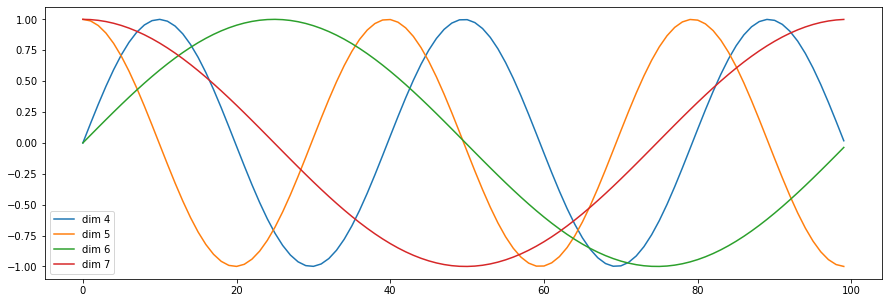

In [4]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

In [45]:
from text_recognizer.networks.densenet import DenseNet,_DenseLayer,_DenseBlock

In [57]:
dnet = DenseNet(12, (6, 12, 10), 1, 24, 80, 4, 0, True)

In [58]:
216 / 8

27.0

In [59]:
summary(dnet, (1, 28, 952), device="cpu", depth=3)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 80]                  --
|    └─Conv2d: 2-1                       [-1, 24, 28, 952]         216
|    └─BatchNorm2d: 2-2                  [-1, 24, 28, 952]         48
|    └─ReLU: 2-3                         [-1, 24, 28, 952]         --
|    └─_DenseBlock: 2-4                  [-1, 96, 28, 952]         --
|    └─_Transition: 2-5                  [-1, 48, 14, 476]         --
|    |    └─Sequential: 3-1              [-1, 48, 14, 476]         4,800
|    └─_DenseBlock: 2-6                  [-1, 192, 14, 476]        --
|    └─_Transition: 2-7                  [-1, 96, 7, 238]          --
|    |    └─Sequential: 3-2              [-1, 96, 7, 238]          18,816
|    └─_DenseBlock: 2-8                  [-1, 216, 7, 238]         --
|    └─ReLU: 2-9                         [-1, 216, 7, 238]         --
|    └─AdaptiveAvgPool2d: 2-10           [-1, 216, 1, 1]           --
|    └─

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 80]                  --
|    └─Conv2d: 2-1                       [-1, 24, 28, 952]         216
|    └─BatchNorm2d: 2-2                  [-1, 24, 28, 952]         48
|    └─ReLU: 2-3                         [-1, 24, 28, 952]         --
|    └─_DenseBlock: 2-4                  [-1, 96, 28, 952]         --
|    └─_Transition: 2-5                  [-1, 48, 14, 476]         --
|    |    └─Sequential: 3-1              [-1, 48, 14, 476]         4,800
|    └─_DenseBlock: 2-6                  [-1, 192, 14, 476]        --
|    └─_Transition: 2-7                  [-1, 96, 7, 238]          --
|    |    └─Sequential: 3-2              [-1, 96, 7, 238]          18,816
|    └─_DenseBlock: 2-8                  [-1, 216, 7, 238]         --
|    └─ReLU: 2-9                         [-1, 216, 7, 238]         --
|    └─AdaptiveAvgPool2d: 2-10           [-1, 216, 1, 1]           --
|    └─

In [84]:
        backbone = nn.Sequential(
            *list(dnet.children())[:][:-4]
        )

In [85]:
backbone

Sequential()

In [29]:
from text_recognizer.networks import WideResidualNetwork

In [9]:
w = WideResidualNetwork(
        in_channels = 1,
        in_planes = 32,
        num_classes = 80,
        depth = 10,
        width_factor = 1,
        dropout_rate = 0.0,
        num_layers = 5,
        activation = "relu",
        use_decoder = False,)

In [10]:
summary(w, (1, 28, 952), device="cpu", depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 2, 60]          --
|    └─Conv2d: 2-1                       [-1, 32, 28, 952]         288
|    └─Sequential: 2-2                   [-1, 32, 28, 952]         18,560
|    └─Sequential: 2-3                   [-1, 64, 14, 476]         57,536
|    └─Sequential: 2-4                   [-1, 128, 7, 238]         229,760
|    └─Sequential: 2-5                   [-1, 256, 4, 119]         918,272
|    └─Sequential: 2-6                   [-1, 512, 2, 60]          3,671,552
Total params: 4,895,968
Trainable params: 4,895,968
Non-trainable params: 0
Total mult-adds (M): 22.36
Input size (MB): 0.10
Forward/backward pass size (MB): 6.51
Params size (MB): 18.68
Estimated Total Size (MB): 25.29


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 2, 60]          --
|    └─Conv2d: 2-1                       [-1, 32, 28, 952]         288
|    └─Sequential: 2-2                   [-1, 32, 28, 952]         18,560
|    └─Sequential: 2-3                   [-1, 64, 14, 476]         57,536
|    └─Sequential: 2-4                   [-1, 128, 7, 238]         229,760
|    └─Sequential: 2-5                   [-1, 256, 4, 119]         918,272
|    └─Sequential: 2-6                   [-1, 512, 2, 60]          3,671,552
Total params: 4,895,968
Trainable params: 4,895,968
Non-trainable params: 0
Total mult-adds (M): 22.36
Input size (MB): 0.10
Forward/backward pass size (MB): 6.51
Params size (MB): 18.68
Estimated Total Size (MB): 25.29

In [46]:
sz= 5

In [47]:
mask = torch.triu(torch.ones(sz, sz), 1)
mask = mask.masked_fill(mask==1, float('-inf'))

In [50]:

h = torch.rand(1, 256, 10, 10)

In [52]:
h.flatten(2).permute(2, 0, 1).shape

torch.Size([100, 1, 256])

In [91]:
h.flatten(2).permute(2, 0, 1).shape

torch.Size([100, 1, 256])

In [48]:
mask


tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [6]:
pred = torch.Tensor([1,21,2,45,31, 81, 1, 79, 79, 79, 2,1,1,1,1, 81, 1, 79, 79, 79, 1,1,1,1,1, 81, 79, 79, 79, 79]).long()
target = torch.Tensor([1,1,1,1,1, 81, 79, 79, 79, 79, 1,1,1,1,1, 81, 79, 79, 79, 79, 1,1,1,1,1, 81, 79, 79, 79, 79]).long()

In [9]:
mask = (target != 79)

In [10]:
mask

tensor([ True,  True,  True,  True,  True,  True, False, False, False, False,
         True,  True,  True,  True,  True,  True, False, False, False, False,
         True,  True,  True,  True,  True,  True, False, False, False, False])

In [11]:
pred * mask

tensor([ 1, 21,  2, 45, 31, 81,  0,  0,  0,  0,  2,  1,  1,  1,  1, 81,  0,  0,
         0,  0,  1,  1,  1,  1,  1, 81,  0,  0,  0,  0])

In [12]:
target * mask

tensor([ 1,  1,  1,  1,  1, 81,  0,  0,  0,  0,  1,  1,  1,  1,  1, 81,  0,  0,
         0,  0,  1,  1,  1,  1,  1, 81,  0,  0,  0,  0])

In [32]:
from text_recognizer.models.metrics import accuracy

In [61]:
pad_indcies = torch.nonzero(target == 79, as_tuple=False)

In [76]:
t1 = torch.nonzero(target == 81, as_tuple=False).squeeze(1)

In [66]:
target.shape[0]

30

In [84]:
t2 = torch.arange(10, target.shape[0] + 1, 10)

In [85]:
t2

tensor([10, 20, 30])

In [89]:
for start, stop in zip(t1, t2):
    pred[start+1:stop] = 79

In [90]:
pred

tensor([ 1,  1,  1,  1,  1, 81, 79, 79, 79, 79,  2,  1,  1,  1,  1, 81, 79, 79,
        79, 79,  1,  1,  1,  1,  1, 81, 79, 79, 79, 79])

In [88]:
[pred[start+1:stop] = 79 for start, stop in zip(t1, t2)]

SyntaxError: invalid syntax (<ipython-input-88-b8a4aef86401>, line 1)

In [69]:
pad_indcies

tensor([[ 6],
        [ 7],
        [ 8],
        [ 9],
        [16],
        [17],
        [18],
        [19],
        [26],
        [27],
        [28],
        [29]])

In [71]:
pred[pad_indcies:pad_indcies] = 79

TypeError: only integer tensors of a single element can be converted to an index

In [50]:
pred.shape

torch.Size([20])

In [51]:
target.shape

torch.Size([20])

In [91]:
accuracy(pred, target)

0.0

In [92]:
acc = (pred == target).sum().float() / target.shape[0]

In [93]:
acc

tensor(0.9667)